# Clustering methods

Import dataset

In [139]:
import pandas as pd
import numpy as np
import math
import matplotlib.pyplot as plt
from collections import Counter
from sklearn.experimental import enable_iterative_imputer  
from sklearn.impute import IterativeImputer
import random

df = pd.read_csv(r'C:\Users\marco\Downloads\HepatitisCdata.csv')
y_true= df["Category"]
df = df.drop("Category", axis=1)


In [3]:
def mice_imputation(df, max_iter=10, random_state=0):
    """
    Perform MICE (Multiple Imputation by Chained Equations) imputation on numerical attributes in a DataFrame.
    Returns:
        pd.DataFrame: The DataFrame with missing values imputed using MICE.
    """
    # Select only the numerical attributes for imputation
    numerical_columns = df.select_dtypes(include=['float64', 'int64']).columns
    df_numerical = df[numerical_columns]

    # Initialize the MICE imputer
    imputer = IterativeImputer(max_iter=max_iter, random_state=random_state)

    # Perform MICE imputation on numerical attributes
    imputed_data = imputer.fit_transform(df_numerical)

    # Convert the imputed data back to a DataFrame
    imputed_df = pd.DataFrame(imputed_data, columns=numerical_columns)

    # Add back the categorical columns to the imputed DataFrame
    categorical_columns = df.select_dtypes(exclude=['float64', 'int64']).columns
    imputed_df[categorical_columns] = df[categorical_columns]
    
    return imputed_df

In [4]:
def normalize_minmax(df, min_val=-1, max_val=1):
    """
    Normalize a list of values to the specified range.
    Returns:
        list: The normalized values within the specified range.
    """
    normalized_df = df.copy()
    
    # Normalize numeric columns
    for column in normalized_df.select_dtypes(include=['number']).columns:
        min_data = normalized_df[column].min()
        max_data = normalized_df[column].max()

        if min_data == max_data:
            raise ValueError(f"All values in column '{column}' are equal. Cannot normalize.")

        normalized_df[column] = (normalized_df[column] - min_data) / (max_data - min_data) * (max_val - min_val) + min_val
    
    return normalized_df

In [5]:
def one_hot_encode_categorical(df):
    """
    Perform one-hot encoding on categorical columns in a DataFrame.

    Returns:
        pd.DataFrame: The DataFrame with categorical columns one-hot encoded.
    """
    # Select only non-numerical (categorical) columns
    categorical_columns = df.select_dtypes(exclude=['number']).columns
    
    # Perform one-hot encoding
    df_encoded = pd.get_dummies(df, columns=categorical_columns)
    df_encoded = df_encoded.astype('int64')
    
    return df_encoded


In [6]:
def clarans():
    

IndentationError: expected an indented block (2567436541.py, line 2)

In [108]:
df_imputed= mice_imputation(df)
df_encoded= one_hot_encode_categorical(df_imputed)
print(df_encoded.info())
df_normalized= normalize_minmax(df_encoded)
df_final = df_normalized.drop("Unnamed: 0", axis=1)
print(df_final.info())

df_normalized.to_csv('normalized.csv',index=False)


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 615 entries, 0 to 614
Data columns (total 14 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   Unnamed: 0  615 non-null    int64
 1   Age         615 non-null    int64
 2   ALB         615 non-null    int64
 3   ALP         615 non-null    int64
 4   ALT         615 non-null    int64
 5   AST         615 non-null    int64
 6   BIL         615 non-null    int64
 7   CHE         615 non-null    int64
 8   CHOL        615 non-null    int64
 9   CREA        615 non-null    int64
 10  GGT         615 non-null    int64
 11  PROT        615 non-null    int64
 12  Sex_f       615 non-null    int64
 13  Sex_m       615 non-null    int64
dtypes: int64(14)
memory usage: 67.4 KB
None
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 615 entries, 0 to 614
Data columns (total 13 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Age     615 non-null    float64
 1   ALB  

In [143]:
def k_means(df, k):
    """
    Perform clustering of a DataFrame.

    Returns:
        Sum of the squared distances between points and centroids
        pd.DataFrame: The DataFrame with the new cluster column.
    """
    # Make a copy of the input DataFrame to avoid modifying the original.
    df_copy = df.copy()

    # Initialize centroids using k-means++ initialization.
    centroids = df_copy.sample(k).values

    # Initialize an empty dictionary to store clusters.
    clusters = {f'c{i}': [] for i in range(1, k + 1)}

    # Iterate until the centroids converge.
    stop = False
    i = 0
    while not stop:
        # Calculate distances and reassign vectors to centroids.
        for idx, row in df_copy.iterrows():
            distances = {}
            for label, centroid in zip(clusters.keys(), centroids):
                distance_to_centroid = np.linalg.norm(row.values - centroid)
                distances[label] = distance_to_centroid

            # Find the closest cluster.
            closest_centroid = min(distances, key=distances.get)

            clusters[closest_centroid].append(idx)

        # Recalculate centroids as the mean of vectors in each cluster.
        centroids_new = pd.DataFrame({centroid: np.mean(df_copy.loc[cluster_indices], axis=0)
                                      for centroid, cluster_indices in clusters.items()})

        # Stopping criteria: if the new calculated centroid is very similar to the actual one or if the number of iterations reaches 50.
        if (abs(centroids_new.T - centroids).max() < 0.1).all() or i == 150:
            stop = True
        else:
            centroids = centroids_new.values.T
            i += 1

    # Calculate the sum of squared distances within clusters.
    sum_squared_distances = 0
    for centroid, cluster_indices in clusters.items():
        centroid_values = centroids_new[centroid].values
        cluster_points = df_copy.loc[cluster_indices].values
        cluster_distances = np.sum(np.linalg.norm(cluster_points - centroid_values, axis=1) ** 2)
        sum_squared_distances += cluster_distances

    # Add a new column to the original DataFrame indicating cluster membership.
    df_copy['cluster'] = [min(clusters, key=lambda x: idx in clusters[x]) for idx in df_copy.index]

    return sum_squared_distances, df_copy


In [168]:
df_final.shape

(615, 13)

In [176]:

def euclidean_distance(point1, point2):
    return np.linalg.norm(point1 - point2)

def clarans(df, k, max_neighbors, num_trials):
    """
    Perform clustering of a DataFrame.

    Returns:
        Array of best clusters
        Values of best cost
    """
    n_samples, n_features = df.shape
    best_cost = float('inf')
    best_clusters = None

    for _ in range(num_trials):
        # Randomly initialize k cluster centers
        centroids_idx = random.sample(range(n_samples), k)
        centroids = df.iloc[centroids_idx].values
        
        for _ in range(max_neighbors):
            # Randomly choose a data point
            current_idx = random.choice(range(n_samples))
            current_point = df.iloc[current_idx].values
            
            # Randomly choose another data point that is not the current point
            neighbor_idx = random.choice([i for i in range(n_samples) if i != current_idx])
            neighbor_point = df.iloc[neighbor_idx].values
            
            # Calculate the total cost before swapping centroids
            current_cost = sum(min(euclidean_distance(current_point, centroid), euclidean_distance(current_point, neighbor_point))
                               for centroid in centroids)
            
            # Swap a centroid with the neighbor_point and calculate the new cost
            new_centroids = [neighbor_point if np.array_equal(centroid, current_point) else centroid for centroid in centroids]
            new_cost = sum(min(euclidean_distance(current_point, centroid), euclidean_distance(current_point, neighbor_point))
                           for centroid in new_centroids)
            
            # If the new cost is lower, update the centroids
            if new_cost < current_cost:
                centroids = new_centroids
        
        # Assign data points to the nearest centroid
        distances = np.array([[euclidean_distance(point, centroid) for centroid in centroids] for point in df.values])
        cluster_assignments = np.argmin(distances, axis=1)
        
        # Calculate the total cost of the current clustering
        total_cost = sum(np.min(euclidean_distance(df.iloc[i].values, centroids[cluster_assignments[i]])) for i in range(n_samples))

        # Update the best clustering if the cost is lower
        if total_cost < best_cost:
            best_cost = total_cost
            best_clusters = cluster_assignments

    return best_clusters, best_cost




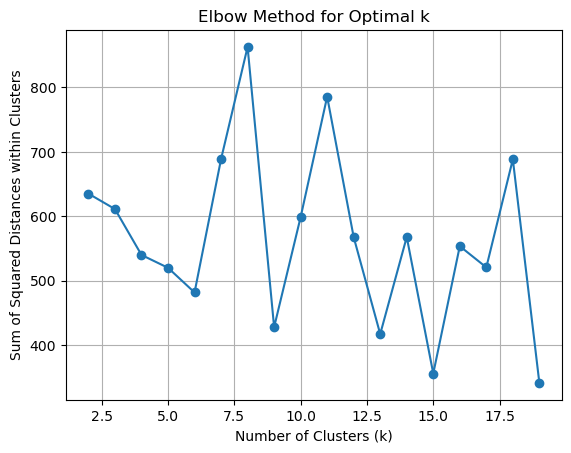

In [145]:
k_values = list(range(2, 20))
sum_squared_distances = []

for k in k_values:
    sse, _ = k_means(df_final, k)
    sum_squared_distances.append(sse)

# Plot the sum of squared distances vs. k to find the elbow point
plt.plot(k_values, sum_squared_distances, marker='o')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Sum of Squared Distances within Clusters')
plt.title('Elbow Method for Optimal k')
plt.grid(True)
plt.show()

In [158]:
sse, df_kmeans = k_means(df_final, 4)

In [159]:
from sklearn.metrics import adjusted_rand_score, normalized_mutual_info_score, confusion_matrix

# Assuming y_true contains the actual labels and df_copy['cluster'] contains cluster assignments
ari = adjusted_rand_score(y_true, df_kmeans['cluster'])
nmi = normalized_mutual_info_score(y_true, df_kmeans['cluster'])
cm = confusion_matrix(y_true, df_kmeans['cluster'])


In [162]:
print("Adjusted Rad Score")
print(ari)

Adjusted Rad Score
-0.06589633816510787


In [177]:
clarans(df_final, k=4, max_neighbors=5, num_trials=10)

(array([3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,
        3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,
        3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,
        3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,
        3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,
        3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,
        3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,
        3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 0, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,
        3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 0, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,
        3, 3, 3, 3, 3, 3, 3, 3, 0, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 0, 3, 3,
        0, 3, 0, 3, 3, 3, 3, 0, 3, 0, 0, 3, 3, 0, 3, 3, 3, 3, 3, 3, 0, 3,
        3, 3, 3, 0, 3, 3, 0, 0, 0, 0, 3, 3, 0, 3, 0, 0, 3, 0, 0, 0, 3, 3,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 3, 0, 0, 0, 0, 0, 0, 0, 0, 0, 3, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 

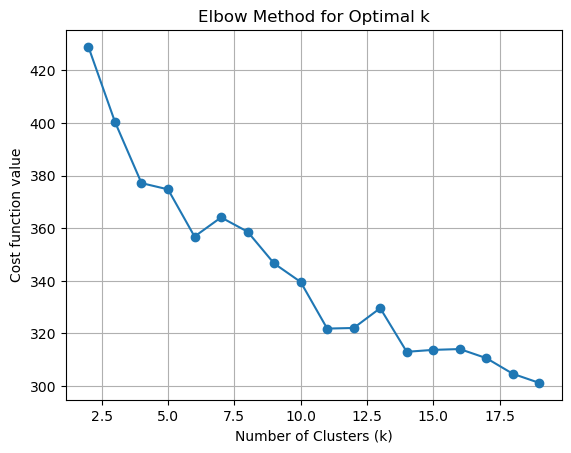

In [181]:
k_values = list(range(2, 20))
cost = []

for k in k_values:
    _, best_cost = clarans(df_final, k, max_neighbors=5, num_trials=30)
    cost.append(best_cost)

# Plot the sum of squared distances vs. k to find the elbow point
plt.plot(k_values, cost, marker='o')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Cost function value')
plt.title('Elbow Method for Optimal k')
plt.grid(True)
plt.show()

In [182]:
clusters,_ = clarans(df_final, k=6, max_neighbors=5, num_trials=10)

In [183]:
# Assuming y_true contains the actual labels and df_copy['cluster'] contains cluster assignments
ari2 = adjusted_rand_score(y_true, clusters)
print("Adjusted Rad Score")
print(ari2)

Adjusted Rad Score
0.01313010858108128
